In [1]:
import gudhi
import numpy as np

from functions.data_loading import get_filtered_data_range
from functions.data_filtering import complete_flight_filter

from gudhi import AlphaComplex
from datetime import datetime
from traffic.core import Traffic

In [2]:
origin = "bergen"
destination = "oslo"

filtered_flights: Traffic = get_filtered_data_range(origin, destination, datetime(year=2023, month=1, day=1), datetime(year=2024, month=1, day=1), complete_flight_filter(origin, destination))

In [3]:
i = 0

In [4]:
i+=1
filtered_flights[197].map_leaflet()

Map(center=[np.float64(60.216230570465214), np.float64(9.156478729990157)], controls=(ZoomControl(options=['po…

In [5]:
lats = filtered_flights[197].data["latitude"].to_numpy()
longs = filtered_flights[197].data["longitude"].to_numpy()

alpha_complex: gudhi.alpha_complex = AlphaComplex(points=zip(lats, longs))
tree: gudhi.simplex_tree.SimplexTree = alpha_complex.create_simplex_tree()

C:\Users\tobso\PycharmProjects\masters-thesis\venv\lib\site-packages\gudhi\persistence_graphical_tools.py:107: UserWarning: usetex mode requires TeX.
  warnings.warn("usetex mode requires TeX.")


<Axes: title={'center': 'Persistence barcode'}>

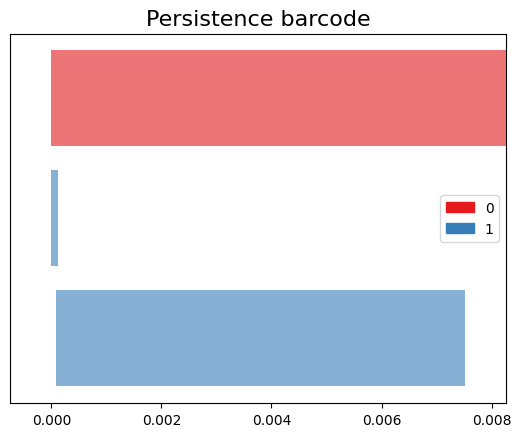

In [6]:
tree.compute_persistence()
gudhi.plot_persistence_barcode(list(filter(lambda x: x[1][1] - x[1][0] > 0.0001, tree.persistence())))

In [7]:
tree.persistence()

[(1, (8.824591408899011e-05, 0.0075094670016651426)),
 (1, (8.331269055960837e-07, 0.0001260880647864972)),
 (1, (1.1575031380412337e-05, 1.2501585986824488e-05)),
 (1, (1.1782008239846783e-05, 1.2287160783560862e-05)),
 (1, (1.1697827318129365e-05, 1.1974863653790388e-05)),
 (1, (1.2254743488731547e-05, 1.24330971334525e-05)),
 (1, (1.2287159719009177e-05, 1.2404524160682198e-05)),
 (1, (4.423677718640391e-07, 5.571426120149874e-07)),
 (1, (2.557197708521848e-07, 3.6872650559560177e-07)),
 (1, (1.008421294000481e-06, 1.1179601522430642e-06)),
 (1, (1.2376129557645377e-05, 1.2478500759428772e-05)),
 (1, (2.858663202754555e-07, 3.7858945577863624e-07)),
 (1, (2.698460787610791e-07, 3.5641216765229253e-07)),
 (1, (2.757641287893685e-07, 3.5124807489330157e-07)),
 (1, (1.221881403092822e-05, 1.2289060956692651e-05)),
 (1, (2.9480801767682e-07, 3.649927808387037e-07)),
 (1, (3.898747968028493e-07, 4.589339330084872e-07)),
 (1, (1.5504310165553575e-07, 2.2027281395578185e-07)),
 (1, (4.2064

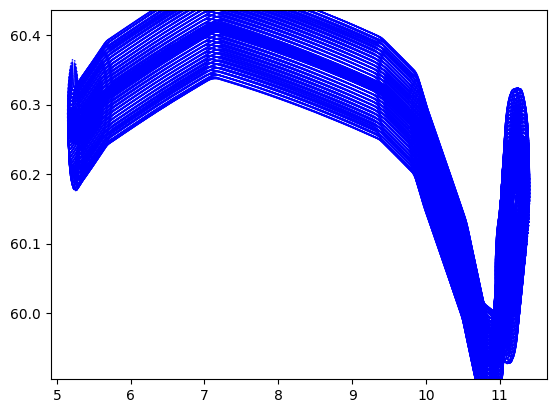

In [13]:
import numpy as np
import matplotlib.pyplot as plt


# Example: points in 2D space
points = np.array(list(zip(longs, lats)))

# Function to plot filtration
def plot_filtration(points, epsilon):
    # Plot points
    plt.scatter(points[:, 0], points[:, 1], color='blue', zorder=2)
    
    # Plot epsilon balls
    for point in points:
        circle = plt.Circle(point, epsilon, color='blue', fill=False, linestyle='dotted')
        plt.gca().add_artist(circle)

    plt.show()

# Example: visualize filtration at epsilon = 0.6
epsilon = 0.075
plot_filtration(points, epsilon)